# Laboratorium 2


### Konfiguracja

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
import math
from operator import itemgetter

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

In [14]:
%matplotlib notebook

## 1 a)

In [4]:
%matplotlib notebook

def mk_rand(n,r):
    PointsA = []
    for x in range(n):
        PointsA.append((random.uniform(-r,r),random.uniform(-r, r)))
    return PointsA

## 1 b)

In [5]:
%matplotlib notebook

def mk_circle(n,r):
    Circle = []
    o = (0,0)  #centre of circle
    for x in range(n):
        t = random.uniform(0, 2*math.pi)
        Circle.append(( r*math.cos(t) + o[0], r*math.sin(t) + o[1]))
    return Circle

## 1 c)

In [6]:
%matplotlib notebook

def mk_rect(n):
    Rectangular = []
    lowLeft = (-10,-10)
    upRight = (10,10)
    def getEdge(edge):
        switcher = {
            1: (lowLeft, (lowLeft[0], upRight[1])),
            2: (lowLeft, (upRight[0], lowLeft[1])),
            3: ((lowLeft[0], upRight[1]), upRight),
            4: ((upRight[0], lowLeft[1]), upRight)
        }
        return switcher.get(edge)

    for i in range(n):
        edge = random.randint(1, 4)
        ends = getEdge(edge)
        t = random.uniform(0,1)
        x = (1-t)*ends[0][0] + t*ends[1][0]
        y = (1-t)*ends[0][1] + t*ends[1][1]
        Rectangular.append((x, y))
    return Rectangular


## 1 d)

In [7]:
 #n1 - number of points on diagonals
 #n2 - number of points on axes

def mk_square(n1,n2):
    upRight = (10,10)     
    lowLeft = (0,0) 
    Square = []
    corn = (lowLeft,upRight)   #adding corners

    for i in range(2):
        for j in range(2):
            Square.append((corn[i][j],corn[j][i]))

    for i in range(n1):
        t = random.uniform(0,1)
        x1 = (1-t)*corn[0][0] + t*corn[1][0]
        y1 = (1-t)*corn[0][1] + t*corn[1][1]
        t = random.uniform(0,1)
        x2= (1-t)*corn[0][1] + t*corn[1][0]
        y2 = (1-t)*corn[1][1] + t*corn[0][1]
        Square.append((x1, y1))
        Square.append((x2, y2))

    ends = ( (lowLeft[0],upRight[1]), (upRight[0],lowLeft[1]) )
    for i in range(2*n2):
        t = random.uniform(0,1)
        x = (1-t)*lowLeft[0] + t*ends[i%2][0]
        y = (1-t)*lowLeft[1] + t*ends[i%2][1]
        Square.append((x, y))
    
    return Square

## Support (Graham)

In [8]:
def dist (p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

ep = 1e-7   #epsilon in det comparison

def orient (p0,p1,px):
    m = [p0[0], p0[1], p1[0], p1[1], px[0], px[1]]
    det = -np.linalg.det(np.concatenate((np.reshape(m, (3, 2)), np.ones((3,1))), axis=1))
    if det < ep and det > -ep:
        if(dist(p0, p1) > dist(p0,px)):         #inline case
            return 1
        else:
            return -1
    return det
    
def merge_sort(x0, Points):
    if len(Points) < 2:
        return Points
    else:
        mid = len(Points)//2
        left = Points[:mid]
        right = Points[mid:]
        merge_sort(x0, left)
        merge_sort(x0, right)
        
        i=j=k=0
        while i < len(left) and j < len(right):
            if orient(x0, left[i],right[j]) > ep :
                Points[k] = left[i]
                i+=1
            else:
                Points[k] = right[j]
                j+=1
            k+=1
        
        while i < len(left):
            Points[k] = left[i]
            i+=1
            k+=1
        while j < len(right):
            Points[k] = right[j]
            j+=1 
            k+=1
    
def angular_sort(Points):
    mp = min(Points, key = lambda x: (x[1], x[0]))
    Points.remove(mp)
    merge_sort(mp, Points)
    prep = [mp] + Points
    Points.append(mp)
    
    return prep


## Graham's algorithm

In [9]:
%matplotlib notebook

def graham( Points, scenes =[]):
    Prep = Points[:]
    #merge sort -> O(n log n)
    Prep = angular_sort(Points)
    
    hull = [Prep[0], Prep[1]]
    
    for i in Prep[2:]:
        
        #printing edges
        edges = []
        for j in range(len(hull) - 1):
            edges.append([ hull[j], hull[j+1] ])
        scenes += [(Scene([PointsCollection(Points), PointsCollection(hull, 'Red', marker='x'), PointsCollection([i], 'Yellow')], [LinesCollection(edges, 'Purple'), LinesCollection([[hull[-1], i]], 'Orange')]))]
        
        #removing hollow vertices
        while len(hull) > 1 and orient(hull[-2], hull[-1], i) < -ep:
            u = hull.pop()
            
        hull.append(i)
        
    hull.append(hull[0])
    scenes.append(Scene( [PointsCollection(Points)], [LinesCollection([hull])] ))
    return hull

### Graham test

<IPython.core.display.Javascript object>


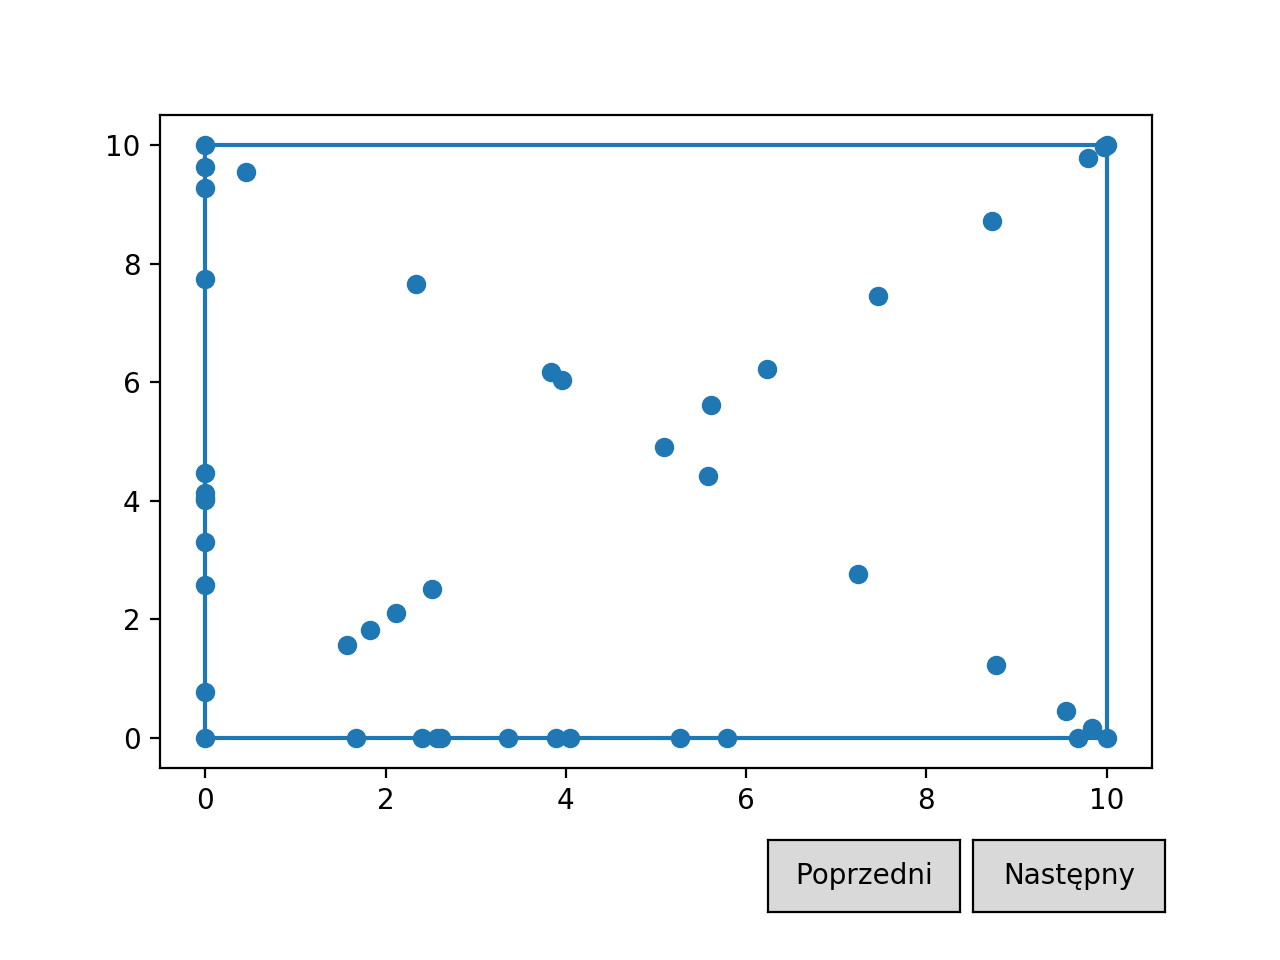

In [29]:
%matplotlib notebook
scenes = []

Points = mk_square(10,10)
x = graham(Points, scenes)

plot = Plot(scenes)
plot.draw()

## Jarvis Algorithm

In [10]:
%matplotlib notebook
        
def jarvis(Points):
    scenes = []
    #i0 with min y
    i = min(Points, key = itemgetter(1))
    hull = []
        
    while True:
        hull.append(i)
        k = Points[0]
        
        for j in Points[1:]:
            #printing edges
            edges = []
            for h in range( len(hull) -1):
                edges.append([hull[h], hull[h+1]])  
            scenes += [(Scene([PointsCollection(Points), PointsCollection(hull, 'Red', marker='x'), PointsCollection([k], 'Yellow'), PointsCollection([j], 'Pink', marker = '+')], [LinesCollection(edges, 'Purple'), LinesCollection([[hull[-1], k], [k,j]], 'Orange')]))]  
            
            #choosing minimal angle to last hull edge
            if i == j:
                continue
            elif k == i or orient(i,k,j) < ep:
                k = j
            elif orient(i,k,j) <= ep:
                if dist(i,k) < dist (i,j):
                    k = j
           
        i = k
        if i == hull[0]:
            break
            
    hull.append(hull[0])
    scenes += [Scene( [PointsCollection(Points)], [LinesCollection([hull])])]
    return hull, scenes   

### Jarvis test

<IPython.core.display.Javascript object>


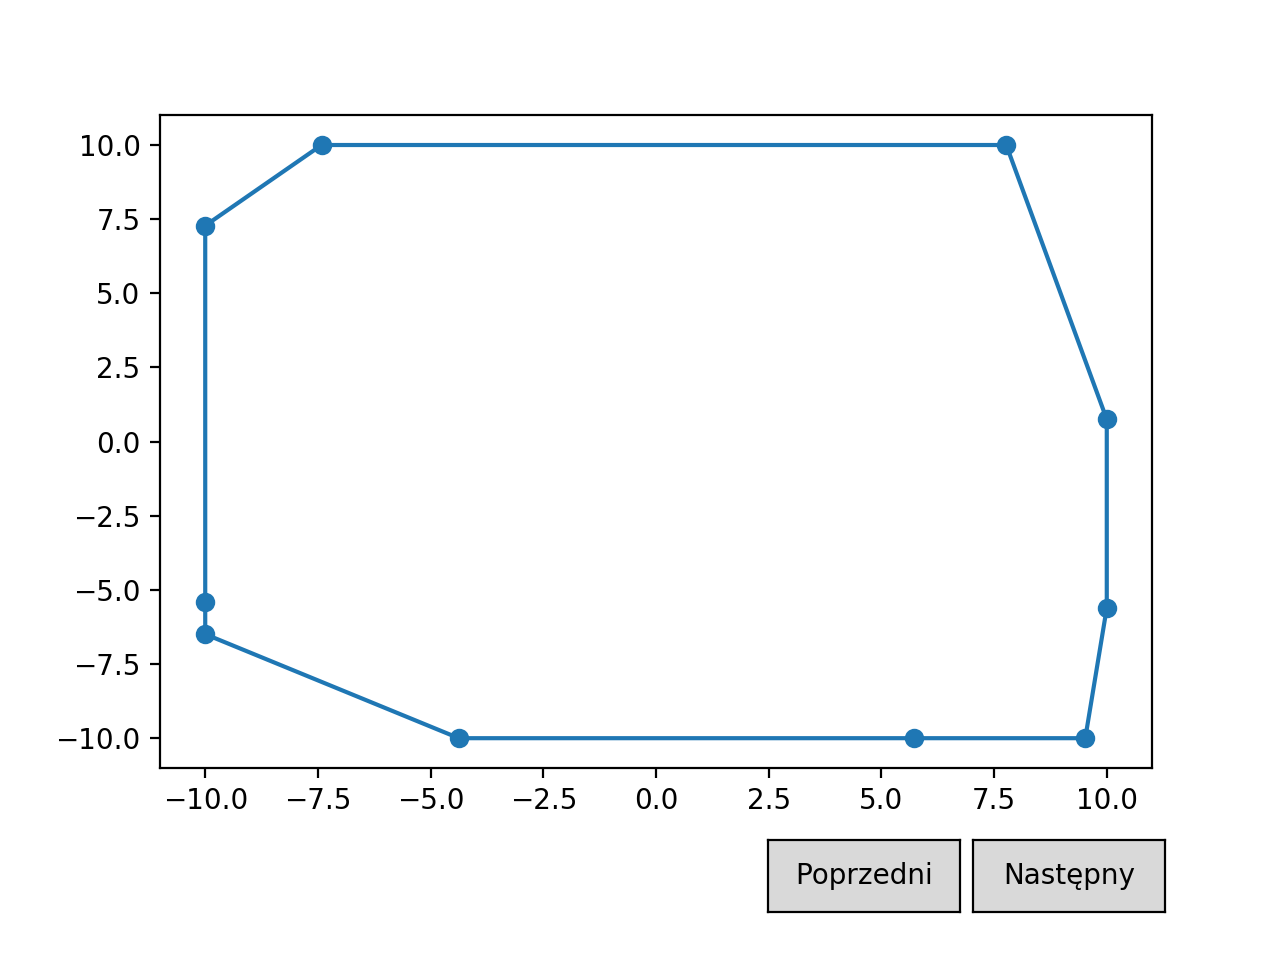

In [36]:
PointsB = mk_rect(10)
y, scenes = jarvis(PointsB)

plot = Plot(scenes)
plot.draw()

## Time comparison

In [13]:
import timeit

# points = mk_rand(10,10)
# points = mk_rand(100,10)
# points = mk_rand(4, 1000)
# points = mk_circle(100, 100)
# points = mk_circle(10, 10)
# points = mk_circle(20, 1)
# points = mk_rect(10)
# points = mk_rect(4)
# points = mk_square(10,10)
# points = mk_square(5, 15)
points = mk_square(30, 15)

print("Jarvis time:")
%timeit jarvis(points)
print("Graham time:")
%timeit graham(points)


Jarvis time:
The slowest run took 10.40 times longer than the fastest. This could mean that an intermediate result is being cached.
167 ms ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Graham time:
44 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
